# HW1 IMU Analysis

End-to-end notebook for exploring Raspberry Pi Pico IMU logs, feature behaviour, and classifier quality for Home Assignment 1.

In [37]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

NOTEBOOK_DIR = Path().resolve()
DATA_DIR = NOTEBOOK_DIR.parents[1] / "logs"
FIG_DIR = NOTEBOOK_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({'figure.figsize': (10, 4)})
plt.rcParams['axes.grid'] = True

FEATURE_COLS = [
    "t_ms","ax","ay","az","gx","gy","gz",
    "amag_mean","amag_std","amag_rms","energy","dom_freq",
    "bp1","bp2","gx_std","gy_std","gz_std",
    "d_pitch_std","d_roll_std","class","lat_ms","q_len"
]
RAW_COLS = ["t_ms","ax","ay","az","gx","gy","gz"]
CLASS_MAP = {0: "NONE", 1: "SHAKE", 2: "TILT", 3: "CIRCLE"}

print(f"Notebook dir: {NOTEBOOK_DIR}")
print(f"Data dir: {DATA_DIR}")
print(f"Figure dir: {FIG_DIR}")

Notebook dir: /Users/samuel/MLES_IMU/MLES_IMU/analysis
Data dir: /Users/samuel/MLES_IMU/logs
Figure dir: /Users/samuel/MLES_IMU/MLES_IMU/analysis/figures


In [38]:
def list_logs(limit: int = 50):
    files = sorted(DATA_DIR.glob("*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    return files[:limit]


def pick_latest():
    files = list_logs(1)
    return files[0] if files else None


def _read_any_csv(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_csv(path)
        if 't_ms' in df.columns:
            return df
    except Exception:
        pass
    try:
        return pd.read_csv(path, sep=r"[\,\t\s]+", engine='python', header=None)
    except Exception as exc:
        raise exc


def load_log(path: Path) -> pd.DataFrame:
    df0 = _read_any_csv(path)
    first_row = df0.iloc[0].tolist() if not df0.empty else []
    width = len(first_row)

    if width >= len(FEATURE_COLS):
        df = pd.read_csv(path, sep=r"[\,\t\s]+", engine='python', header=None, names=FEATURE_COLS, index_col=False)
        df.attrs['mode'] = 'features'
    elif width >= len(RAW_COLS):
        df = pd.read_csv(path, sep=r"[\,\t\s]+", engine='python', header=None, names=RAW_COLS, index_col=False)
        df.attrs['mode'] = 'raw'
    else:
        df = pd.read_csv(path)
        if set(FEATURE_COLS).issubset(df.columns):
            df.attrs['mode'] = 'features'
        elif set(RAW_COLS).issubset(df.columns):
            df.attrs['mode'] = 'raw'
        else:
            raise ValueError(f"Unrecognized schema for {path}")

    df = df[pd.to_numeric(df['t_ms'], errors='coerce').notna()].copy()
    df['t_ms'] = df['t_ms'].astype(float)
    df['t_s'] = df['t_ms'] / 1000.0

    if df.attrs.get('mode') == 'features' and 'class' in df.columns:
        df['class'] = pd.to_numeric(df['class'], errors='coerce').fillna(-1).astype(int)
        df['class_name'] = df['class'].map(CLASS_MAP).fillna('UNKNOWN')

    df.attrs['path'] = str(path)
    return df

In [39]:
def plot_raw(df: pd.DataFrame, duration_s: float = 5.0):
    if df.attrs.get('mode') != 'raw':
        raise ValueError('Expected RAW dataframe')
    if df.empty:
        raise ValueError('Dataframe has no samples')

    stem = Path(df.attrs.get('path', 'raw')).stem
    end_time = df['t_s'].iloc[0] + duration_s
    dfp = df[df['t_s'] <= end_time]

    fig, ax = plt.subplots()
    ax.plot(dfp['t_s'], dfp[['ax','ay','az']])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Accel [g]')
    ax.set_title('RAW accelerometer')
    fig.tight_layout()
    out = FIG_DIR / f"raw_accel_{stem}.png"
    fig.savefig(out, dpi=200)
    plt.show()

    if {'gx','gy','gz'}.issubset(dfp.columns):
        fig, ax = plt.subplots()
        ax.plot(dfp['t_s'], dfp[['gx','gy','gz']])
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Gyro [dps]')
        ax.set_title('RAW gyroscope')
        fig.tight_layout()
        out = FIG_DIR / f"raw_gyro_{stem}.png"
        fig.savefig(out, dpi=200)
        plt.show()


def plot_features(df: pd.DataFrame):
    if df.attrs.get('mode') != 'features':
        raise ValueError('Expected FEATURE dataframe')
    if df.empty:
        raise ValueError('Dataframe has no samples')

    stem = Path(df.attrs.get('path', 'features')).stem

    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    axes[0].plot(df['t_s'], df['amag_std'])
    axes[0].set_ylabel('amag_std')
    axes[0].set_title('Feature trace: amag_std')

    if 'dom_freq' in df.columns:
        axes[1].plot(df['t_s'], df['dom_freq'])
        axes[1].set_ylabel('dom_freq [Hz]')
    else:
        axes[1].plot(df['t_s'], np.zeros_like(df['t_s']))
        axes[1].set_ylabel('dom_freq (missing)')
    axes[1].set_title('Feature trace: dom_freq')

    gyro_cols = [c for c in ['gx_std','gy_std','gz_std'] if c in df.columns]
    if gyro_cols:
        axes[2].plot(df['t_s'], df[gyro_cols])
        axes[2].legend(gyro_cols, loc='upper right')
    else:
        axes[2].plot(df['t_s'], np.zeros_like(df['t_s']))
    axes[2].set_ylabel('gyro std [dps]')
    axes[2].set_title('Feature trace: gyro std')

    if 'class_name' in df.columns:
        class_ids = df['class'].astype(int).to_numpy()
        axes[3].scatter(df['t_s'], class_ids, c=class_ids, cmap='tab10', s=10)
        axes[3].set_ylabel('class id')
    else:
        axes[3].plot(df['t_s'], np.zeros_like(df['t_s']))
        axes[3].set_ylabel('class (missing)')
    axes[3].set_xlabel('Time [s]')
    axes[3].set_title('Predicted class timeline')

    fig.tight_layout()
    out = FIG_DIR / f"feature_traces_{stem}.png"
    fig.savefig(out, dpi=200)
    plt.show()

In [40]:
def quantize_bits(x, bits):
    scale = (1 << (bits - 1)) - 1
    clipped = np.clip(np.asarray(x, dtype=float), -1.0, 1.0)
    q_int = np.round(clipped * scale).astype(int)
    dequant = q_int.astype(float) / scale
    return q_int, dequant


def snr_and_error(ref, test):
    ref = np.asarray(ref, dtype=float)
    test = np.asarray(test, dtype=float)
    err = ref - test
    signal_power = np.mean(ref ** 2)
    noise_power = np.mean(err ** 2)
    if noise_power == 0:
        snr_db = np.inf
    elif signal_power == 0:
        snr_db = -np.inf
    else:
        snr_db = 10.0 * np.log10(signal_power / noise_power)
    rms_err = np.sqrt(noise_power)
    max_err = np.max(np.abs(err))
    return snr_db, rms_err, max_err


def quantization_report(df, cols, bits_list=(16, 8, 4), max_hist=3):
    records = []
    hist_plotted = 0
    for col in cols:
        series = df[col].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if series.empty:
            continue
        span = np.max(np.abs(series))
        if not np.isfinite(span) or span == 0:
            continue
        norm = np.clip(series / span, -1.0, 1.0)
        for bits in bits_list:
            q_int, deq_norm = quantize_bits(norm, bits)
            deq = deq_norm * span
            snr_db, rms_err, max_err = snr_and_error(series, deq)
            records.append({
                'feature': col,
                'bits': bits,
                'scale': span,
                'snr_db': snr_db,
                'rms_error': rms_err,
                'max_error': max_err,
                'bytes_per_sample': bits / 8.0
            })
        if hist_plotted < max_hist:
            _, deq_norm = quantize_bits(norm, 8)
            deq = deq_norm * span
            fig, ax = plt.subplots(figsize=(8, 4))
            ax.hist(series, bins=50, alpha=0.6, label='float32')
            ax.hist(deq, bins=50, alpha=0.6, label='8-bit dequant')
            ax.set_title(f'Histogram comparison: {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('count')
            ax.legend()
            fig.tight_layout()
            out = FIG_DIR / f"hist_{col}.png"
            fig.savefig(out, dpi=200)
            plt.show()
            hist_plotted += 1
    return pd.DataFrame(records)

In [41]:
def downsample_features(df, factor=2):
    return df.iloc[::factor].reset_index(drop=True)


def sampling_rate_analysis(df, columns=None):
    if df.attrs.get('mode') != 'features':
        raise ValueError('Expected FEATURE dataframe')
    if columns is None:
        columns = ['amag_std', 'dom_freq', 'gx_std', 'gy_std', 'gz_std']
    columns = [c for c in columns if c in df.columns]
    if not columns:
        raise ValueError('No comparable columns available')

    half = downsample_features(df, factor=2)
    rows = []
    for label, data in [('100 Hz', df), ('50 Hz (downsampled)', half)]:
        row = {'dataset': label, 'samples': len(data)}
        for col in columns:
            row[f'{col}_mean'] = data[col].mean()
            row[f'{col}_std'] = data[col].std()
        rows.append(row)
    summary = pd.DataFrame(rows)

    if 'dom_freq' in columns:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(df['t_s'], df['dom_freq'], label='100 Hz')
        ax.plot(half['t_s'], half['dom_freq'], label='50 Hz (downsampled)', linestyle='--')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('dom_freq [Hz]')
        ax.set_title('Dominant frequency vs sampling rate')
        ax.legend()
        fig.tight_layout()
        out = FIG_DIR / 'dom_freq_sampling_compare.png'
        fig.savefig(out, dpi=200)
        plt.show()

    return summary

In [42]:
import re

def expected_from_filename(path: Path):
    name = path.stem.lower()
    for key in ['shake', 'tilt', 'circle', 'none']:
        if key in name:
            return key.upper()
    return 'UNKNOWN'


def confusion_from_logs(paths):
    records = []
    for p in paths:
        df = load_log(p)
        if df.attrs.get('mode') != 'features' or 'class_name' not in df.columns:
            continue
        expected = expected_from_filename(p)
        for pred in df['class_name'].values:
            records.append((expected, pred))
    if not records:
        return None, None
    expected_series = pd.Series([e for e, _ in records], name='expected')
    predicted_series = pd.Series([p for _, p in records], name='predicted')
    cm_df = pd.crosstab(expected_series, predicted_series, dropna=False)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_df.values, aspect='auto')
    ax.set_xticks(range(cm_df.shape[1]))
    ax.set_xticklabels(cm_df.columns, rotation=45)
    ax.set_yticks(range(cm_df.shape[0]))
    ax.set_yticklabels(cm_df.index)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Expected class')
    ax.set_title('Confusion matrix')
    fig.colorbar(im, ax=ax, shrink=0.8)
    fig.tight_layout()
    out = FIG_DIR / 'confusion_matrix.png'
    fig.savefig(out, dpi=200)
    plt.show()
    return cm_df, cm_df.sum(axis=1)

In [43]:
# ==== Drop-in cell: helpers, labeling, plots, summaries ====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths (adjust if you changed layout)
NOTEBOOK_DIR = Path().resolve()
DATA_DIR = NOTEBOOK_DIR.parents[1] / "logs"
FIG_DIR = NOTEBOOK_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({'figure.figsize': (10, 4), 'axes.grid': True})

FEATURE_COLS = ["t_ms","ax","ay","az","gx","gy","gz",
                "amag_mean","amag_std","amag_rms","energy","dom_freq",
                "bp1","bp2","gx_std","gy_std","gz_std",
                "d_pitch_std","d_roll_std","class","lat_ms","q_len"]
RAW_COLS = ["t_ms","ax","ay","az","gx","gy","gz"]

# Class names
CLASS_MAP = {0: "NONE", 1: "SHAKE", 2: "TILT", 3: "CIRCLE"}
CLASS_ORDER = [0, 1, 2, 3]
CLASS_LABELS = [CLASS_MAP[i] for i in CLASS_ORDER]

def list_logs(limit=50):
    return sorted(DATA_DIR.glob("*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)[:limit]

def pick_latest():
    files = list_logs(1)
    return files[0] if files else None

def load_log(path: Path) -> pd.DataFrame:
    """Robustly load Pico CSV; detect schema; add time (s) and class_name."""
    # try headered
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, sep=r"[,\t\s]+", engine="python", header=None)

    # If no header, infer by width and re-read with names
    if not {"t_ms"}.issubset(df.columns):
        first = open(path).readline().strip()
        n_fields = len([x for x in first.replace("\t", ",").split(",") if x != ""])
        sep = r"[,\t\s]+"
        if n_fields >= len(FEATURE_COLS):
            df = pd.read_csv(path, sep=sep, engine="python", header=None, names=FEATURE_COLS)
        else:
            df = pd.read_csv(path, sep=sep, engine="python", header=None, names=RAW_COLS)

    # keep numeric rows
    df = df[pd.to_numeric(df["t_ms"], errors="coerce").notna()].copy()
    df["t_s"] = df["t_ms"].astype(float) / 1000.0
    # detect mode
    if set(["amag_std","class"]).issubset(df.columns):
        df.attrs["mode"] = "features"
        df["class_name"] = df["class"].map(CLASS_MAP)
    else:
        df.attrs["mode"] = "raw"
    df.attrs["path"] = str(path)
    return df

# ---------- Plots with full labels/titles ----------
def plot_raw(df: pd.DataFrame, duration_s=5.0):
    if df.attrs.get("mode") != "raw":
        raise ValueError("Expected RAW dataframe")

    t0 = float(df["t_s"].iloc[0])
    dfp = df[df["t_s"] <= t0 + float(duration_s)].copy()

    # Acceleration
    plt.figure()
    plt.plot(dfp["t_s"].values, dfp[["ax","ay","az"]].values)
    plt.xlabel("Time [s]")
    plt.ylabel("Acceleration [g]")
    plt.title("Raw accelerometer: ax, ay, az")
    plt.legend(["ax", "ay", "az"], loc="upper right")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "raw_accel.png", dpi=200)
    plt.show()

    # Gyroscope
    if {"gx","gy","gz"}.issubset(dfp.columns):
        plt.figure()
        plt.plot(dfp["t_s"].values, dfp[["gx","gy","gz"]].values)
        plt.xlabel("Time [s]")
        plt.ylabel("Angular rate [°/s]")
        plt.title("Raw gyroscope: gx, gy, gz")
        plt.legend(["gx", "gy", "gz"], loc="upper right")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "raw_gyro.png", dpi=200)
        plt.show()

def plot_features(df: pd.DataFrame):
    if df.attrs.get("mode") != "features":
        raise ValueError("Expected FEATURE dataframe")

    # amag_std
    plt.figure()
    plt.plot(df["t_s"].values, df["amag_std"].values)
    plt.xlabel("Time [s]")
    plt.ylabel("amag_std [g]")
    plt.title("Feature trace: accel magnitude std (HPF)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "feat_amag_std.png", dpi=200)
    plt.show()

    # dom_freq
    if "dom_freq" in df.columns:
        plt.figure()
        plt.plot(df["t_s"].values, df["dom_freq"].values)
        plt.xlabel("Time [s]")
        plt.ylabel("Dominant frequency [Hz]")
        plt.title("Feature trace: dominant frequency of HPF(amag)")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "feat_dom_freq.png", dpi=200)
        plt.show()

    # gyro stds
    keep = [c for c in ["gx_std","gy_std","gz_std"] if c in df.columns]
    if keep:
        plt.figure()
        plt.plot(df["t_s"].values, df[keep].values)
        plt.xlabel("Time [s]")
        plt.ylabel("Gyro std [°/s]")
        plt.title("Feature trace: gyro std per axis")
        plt.legend(keep, loc="upper right")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "feat_gyro_std.png", dpi=200)
        plt.show()

    # predicted class timeline (named y-ticks)
    if "class" in df.columns:
        plt.figure()
        plt.step(df["t_s"].values, df["class"].values, where="post")
        plt.xlabel("Time [s]")
        plt.ylabel("Class")
        plt.yticks(CLASS_ORDER, CLASS_LABELS)
        plt.title("Predicted class over time")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "feat_class.png", dpi=200)
        plt.show()

# ---------- Summary for report ----------
def summarize_features(df: pd.DataFrame):
    """Return (summary_table, class_counts or None)."""
    if df.attrs.get("mode") != "features":
        raise ValueError("Expected FEATURE dataframe")
    cols = [c for c in ["amag_std","dom_freq","bp1","bp2","gx_std","gy_std","gz_std","lat_ms"] if c in df.columns]
    summary = df[cols].describe().T[["count","mean","std","min","25%","50%","75%","max"]]
    counts = df["class_name"].value_counts() if "class_name" in df.columns else None
    return summary, counts


In [44]:
try:
    import ipywidgets as widgets
    files = list_logs()
    if files:
        dropdown = widgets.Dropdown(options=[p.name for p in files], description='Log')
        output = widgets.Output()

        def on_change(change):
            if change['name'] == 'value' and change['new']:
                path = DATA_DIR / change['new']
                with output:
                    output.clear_output(wait=True)
                    print(f'Loading: {path}')
                    df = load_log(path)
                    print('Mode:', df.attrs.get('mode'))
                    display(df.head())
        dropdown.observe(on_change, names='value')
        display(dropdown, output)
except ImportError:
    pass

Latest file: /Users/samuel/MLES_IMU/logs/imu_log_01_10_2025_2.csv
Mode: features
Samples: 78


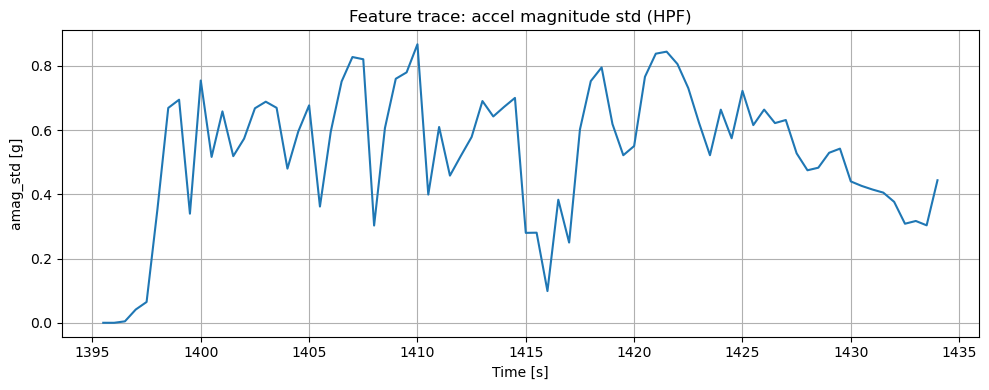

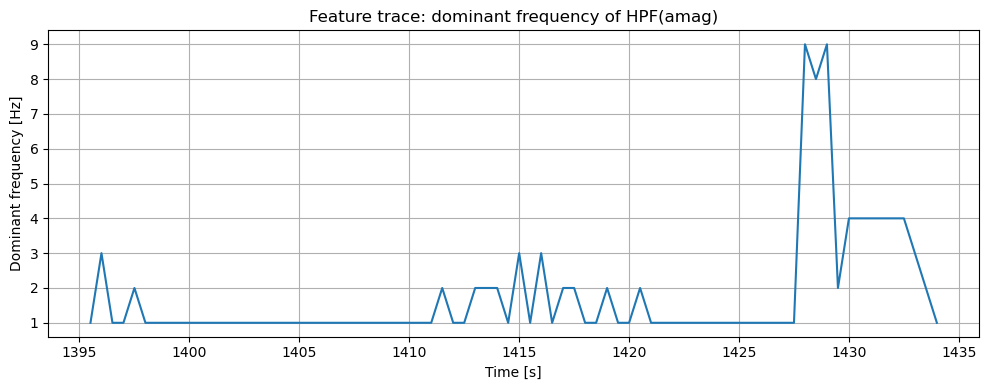

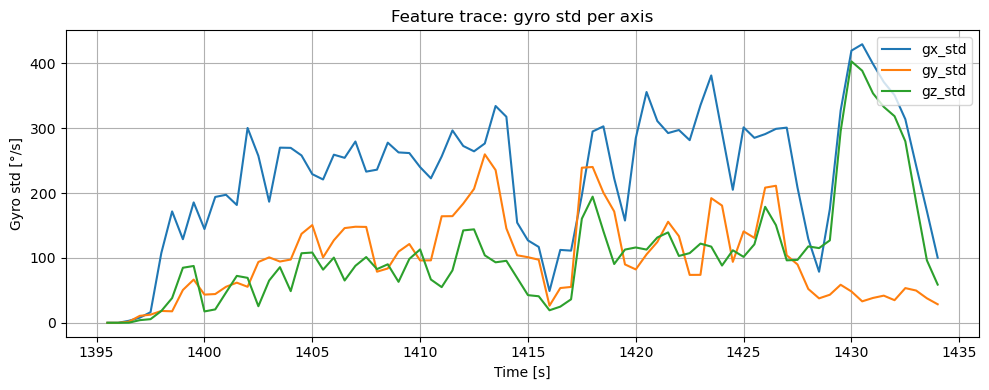

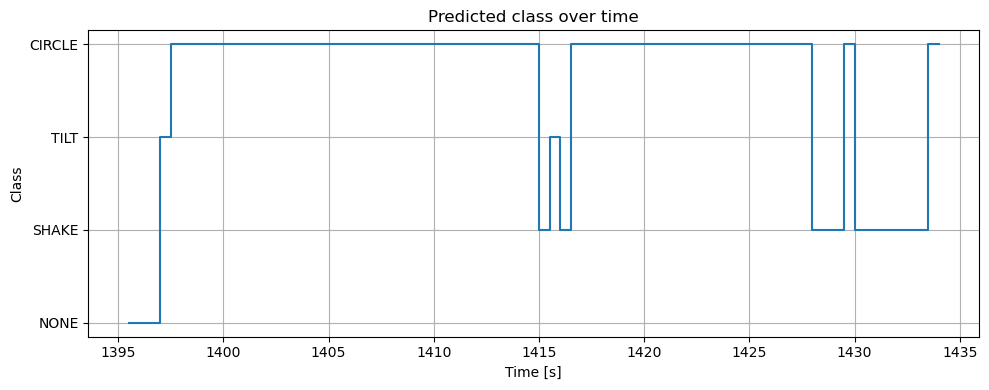

,count,mean,std,min,25%,50%,75%,max
amag_std,78.0,0.534086,0.212296,0.00033,0.407798,0.576505,0.675755,0.86708
dom_freq,78.0,1.769231,1.658689,1.00000,1.000000,1.000000,2.000000,9.00000
bp1,78.0,379.036048,373.256986,0.00005,82.850335,272.243565,571.966567,1667.87122
bp2,78.0,91.273557,109.042370,0.00006,11.529945,37.133565,173.830782,464.53183
gx_std,78.0,230.265163,99.262200,0.02134,173.012497,256.990250,296.276032,429.54840
gy_std,78.0,99.625341,63.980888,0.01584,49.984485,94.259090,144.404468,259.78278
gz_std,78.0,108.680454,85.733957,0.02123,63.690090,96.322275,120.215745,403.11139
lat_ms,78.0,6.065654,0.013782,6.02500,6.056250,6.065000,6.074750,6.11500


Class distribution:


CIRCLE    61
SHAKE     12
NONE       3
TILT       2
Name: class_name, dtype: int64

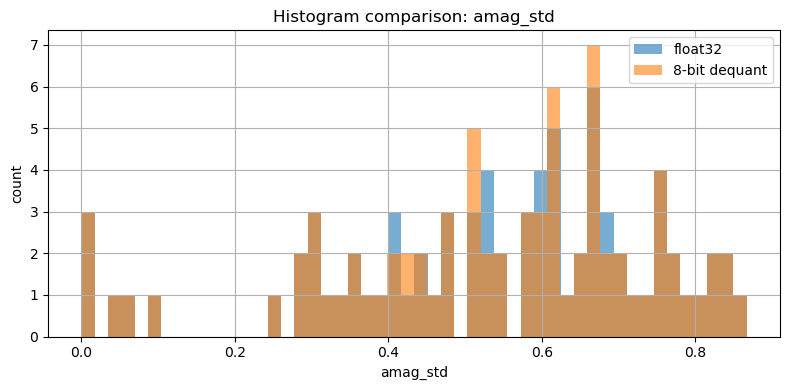

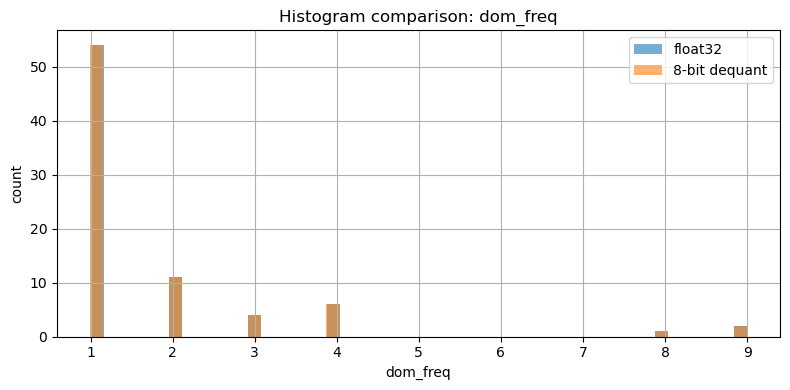

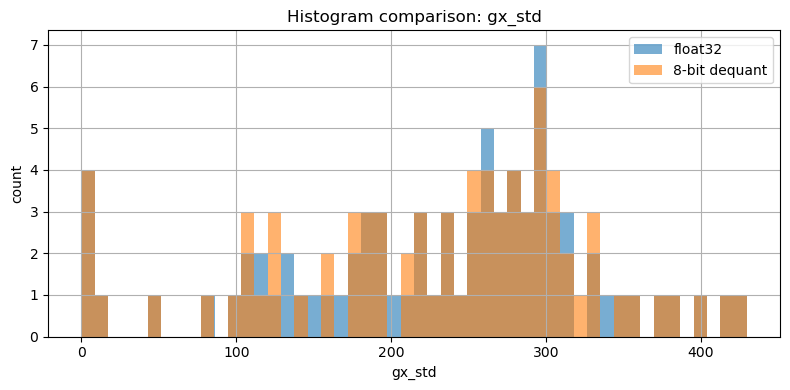

,feature,bits,scale,snr_db,rms_error,max_error,bytes_per_sample
2,amag_std,4,0.86708,24.139222,0.035655,0.061590,0.5
1,amag_std,8,0.86708,49.366017,0.001953,0.003407,1.0
0,amag_std,16,0.86708,97.597847,0.000008,0.000013,2.0
5,dom_freq,4,9.00000,17.076868,0.338526,0.571429,0.5
4,dom_freq,8,9.00000,45.029603,0.013550,0.031496,1.0
3,dom_freq,16,9.00000,90.483641,0.000072,0.000122,2.0
8,gx_std,4,429.54840,23.757873,16.252073,30.333740,0.5
7,gx_std,8,429.54840,49.341968,0.854484,1.667755,1.0
6,gx_std,16,429.54840,96.835524,0.003606,0.006512,2.0
11,gy_std,4,259.78278,20.153106,11.611414,18.442804,0.5


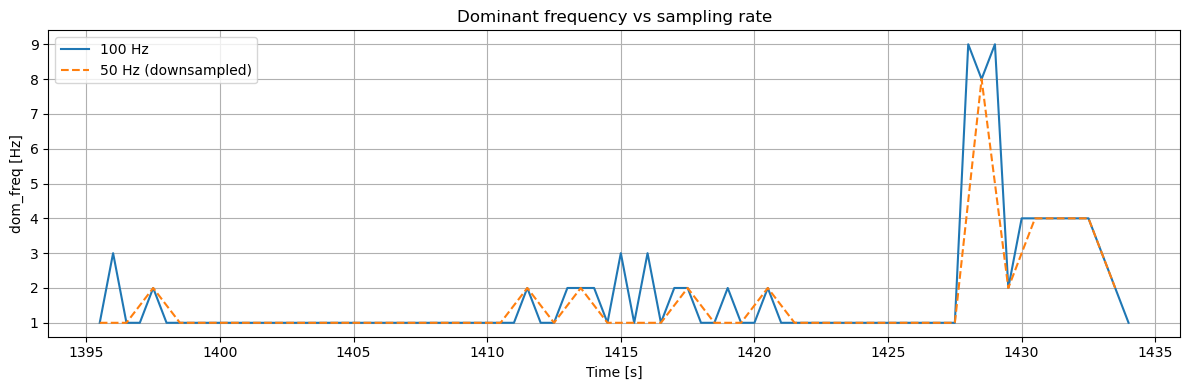

,dataset,samples,amag_std_mean,amag_std_std,dom_freq_mean,dom_freq_std,gx_std_mean,gx_std_std,gy_std_mean,gy_std_std,gz_std_mean,gz_std_std
0,100 Hz,78,0.534086,0.212296,1.769231,1.658689,230.265163,99.262200,99.625341,63.980888,108.680454,85.733957
1,50 Hz (downsampled),39,0.523061,0.209321,1.589744,1.351762,229.453820,100.451544,100.884347,64.321567,109.787038,85.283069


/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_17195/84638933.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.8)


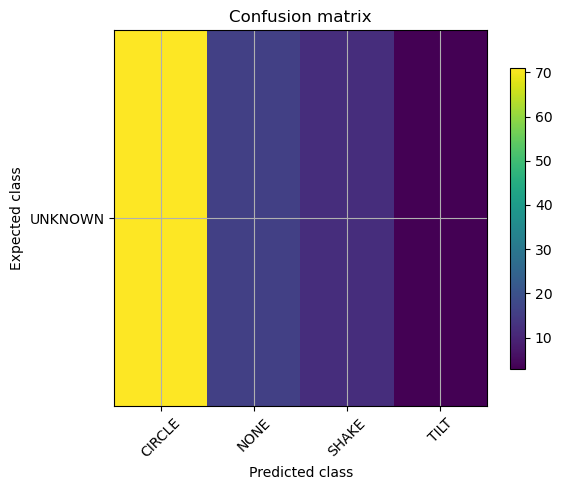

predicted,CIRCLE,NONE,SHAKE,TILT
expected,,,,
UNKNOWN,71,16,12,3


,total_samples
expected,
UNKNOWN,102


In [45]:
latest = pick_latest()
print('Latest file:', latest)
if latest is None:
    print('No CSV logs found in', DATA_DIR)
else:
    df = load_log(latest)
    print('Mode:', df.attrs.get('mode'))
    print('Samples:', len(df))
    if df.attrs.get('mode') == 'raw':
        plot_raw(df, duration_s=5.0)
        display(df.head())
    else:
        plot_features(df)
        summary, counts = summarize_features(df)
        display(summary)
        if counts is not None:
            print('Class distribution:')
            display(counts)
        quant_cols = [c for c in ['amag_std','dom_freq','gx_std','gy_std','gz_std'] if c in df.columns]
        if quant_cols:
            qdf = quantization_report(df, quant_cols)
            display(qdf.sort_values(['feature','bits']))
        try:
            sampling_summary = sampling_rate_analysis(df)
            display(sampling_summary)
        except ValueError as exc:
            print('Sampling comparison skipped:', exc)
        cm, totals = confusion_from_logs(list_logs(40))
        if cm is not None:
            display(cm)
            display(totals.to_frame('total_samples'))